In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define drift and diffusion functions
def mu(x, coupling_constants):
    return -0.5 * x + coupling_constants[0] * x

def sigma(x, coupling_constants):
    return 0.1 * (1 + coupling_constants[1])  # Ensure non-negative diffusion

class Time_Series_Generator:
    def __init__(self, num_nodes, coupling_constants, correlation_matrix):
        self.num_nodes = num_nodes
        self.coupling_constants = coupling_constants
        self.correlation_matrix = correlation_matrix
        self.correlation_decomposition = np.linalg.cholesky(correlation_matrix)  # Cholesky decomposition
        self.time_series = None

    def simulate_sde(self, mu, sigma, dt, num_steps):
        self.time_series = np.full((self.num_nodes, num_steps), 10.0)  # Initialize time series
        
        for t in range(1, num_steps):
            dW = np.random.normal(size=self.num_nodes) * np.sqrt(dt)
            correlated_noise = np.dot(self.correlation_decomposition, dW)
            
            drift = mu(self.time_series[:, t-1], self.coupling_constants) * dt
            diffusion = sigma(self.time_series[:, t-1], self.coupling_constants) * correlated_noise
            
            # Avoid overflow by capping drift and diffusion at smaller values
            drift = np.clip(drift, -5, 5)
            diffusion = np.clip(diffusion, -5, 5)
            
            # Additive update to avoid exponential growth and overflow
            self.time_series[:, t] = self.time_series[:, t-1] + drift + diffusion
            
            # Ensure the time series doesn't grow too large or become NaN
            self.time_series[:, t] = np.clip(self.time_series[:, t], -100, 100)

            # Check for any NaN values in time series (result from overflow)
            if np.any(np.isnan(self.time_series[:, t])):
                raise ValueError("NaN values encountered during simulation. Adjust the clipping or step size.")

    def get_correlation_matrix(self):
        if self.time_series is None:
            raise ValueError("Time series has not been simulated yet.")
        return np.corrcoef(self.time_series)

# Define parameter ranges for grid search
def create_grid(start, end, step):
    return np.arange(start, end + step, step)

def grid_search(num_nodes, target_correlation_matrix, dt, num_steps, parameter_ranges):
    best_error = float('inf')
    best_params = None
    
    # Create a grid of parameter combinations
    grids = [create_grid(start, end, step) for start, end, step in parameter_ranges]
    
    for coupling1 in grids[0]:
        for coupling2 in grids[1]:
            # Define coupling constants for the current grid point
            coupling_constants = np.array([coupling1, coupling2])
            
            # Create and simulate generator
            generator = Time_Series_Generator(num_nodes, coupling_constants, target_correlation_matrix)
            generator.simulate_sde(mu, sigma, dt, num_steps)
            simulated_correlation_matrix = generator.get_correlation_matrix()
            
            # Compute the error
            error = np.sum((simulated_correlation_matrix - target_correlation_matrix) ** 2)
            
            # Update the best parameters if the current error is lower
            if error < best_error:
                best_error = error
                best_params = coupling_constants
    
    return best_params, best_error

In [2]:
# Example usage
num_nodes = 5

# High correlation
target_correlation_matrix = np.array([
    [1.0, 0.9, 0.90, 0.8, 0.75],
    [0.9, 1.0, 0.88, 0.82, 0.78],
    [0.85, 0.88, 1.0, 0.86, 0.8],
    [0.8, 0.82, 0.86, 1.0, 0.85],
    [0.75, 0.78, 0.8, 0.85, 1.0]
])

dt = 0.01
num_steps = 1000

# Define parameter ranges for coupling constants
parameter_ranges = [(0.0, 1.0, 0.1), (0.0, 1.0, 0.1)]  # (start, end, step) for each constant

# Perform grid search
best_params, best_error = grid_search(num_nodes, target_correlation_matrix, dt, num_steps, parameter_ranges)

# Simulate with best parameters
t_series = Time_Series_Generator(num_nodes, best_params, target_correlation_matrix)
t_series.simulate_sde(mu, sigma, dt, num_steps)

In [3]:
print("Best coupling constants:", best_params)
print("Best error:", best_error)

Best coupling constants: [0.5 0.5]
Best error: 0.09615552388031524


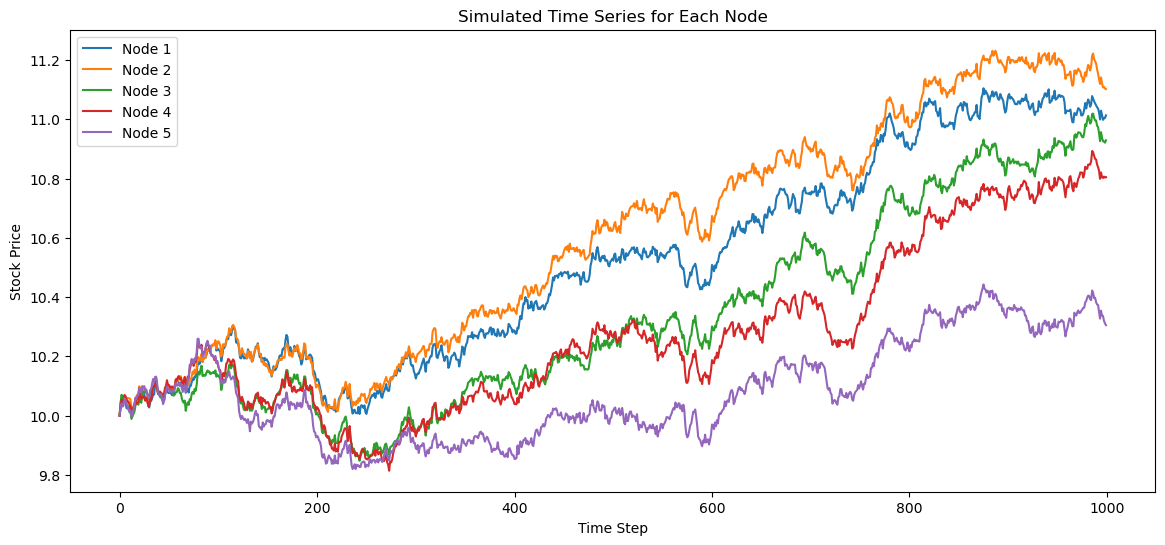

In [4]:
# Plotting the time series
plt.figure(figsize=(14, 6))
for i in range(num_nodes):
    plt.plot(t_series.time_series[i, :], label=f'Node {i+1}')
plt.title('Simulated Time Series for Each Node')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

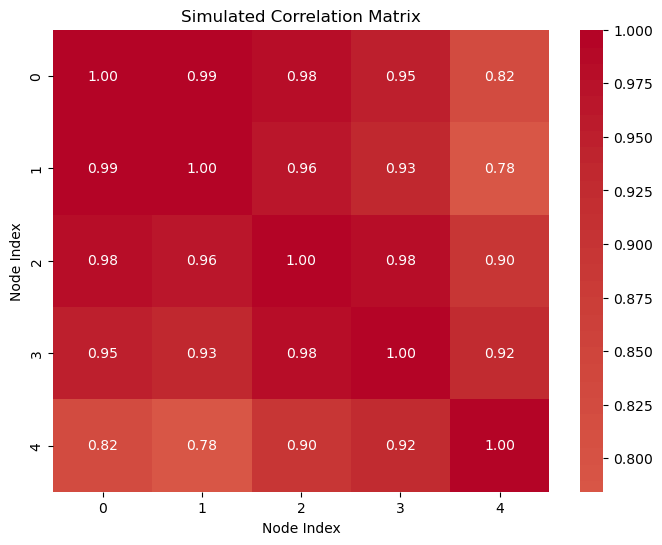

In [5]:
# Plotting the correlation matrix
simulated_correlation_matrix = t_series.get_correlation_matrix()
plt.figure(figsize=(8, 6))
sns.heatmap(simulated_correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Simulated Correlation Matrix')
plt.xlabel('Node Index')
plt.ylabel('Node Index')
plt.show()

In [40]:
#Time series of a single node rescaled to match a stock-price
import pandas as pd

# Convert one of the nodes' time series to stock prices
node_index = 3  # Choose the node index to use
price_series = t_series.time_series[node_index]

# Normalize the stock prices to a realistic range
min_price, max_price = 50, 300
normalized_prices = np.interp(price_series, (price_series.min(), price_series.max()), (min_price, max_price))

# Create a date range for one year
dates = pd.date_range(start='2023-01-01', periods=num_steps, freq='D')
df = pd.DataFrame(data={'Date': dates, 'StockPrice': normalized_prices})
days=len(df['Date'])

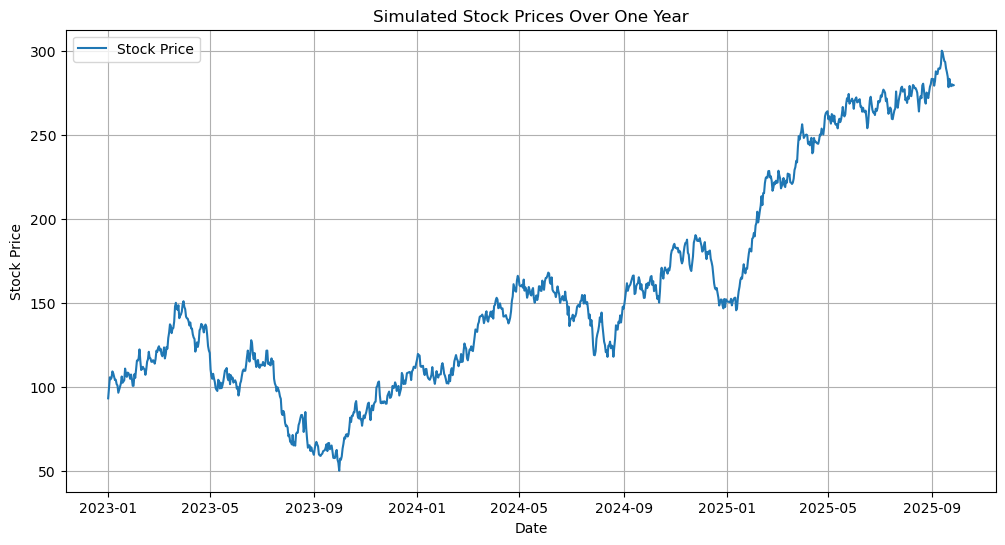

In [41]:
# Plot the stock prices
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['StockPrice'], label='Stock Price')
plt.title('Simulated Stock Prices Over One Year')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
import numpy as np
from mesa import Agent, Model, DataCollector
from mesa.time import RandomActivation

In [43]:
class StockTradingAgent(Agent):
    """An agent that trades stocks."""
    
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.portfolio = 10000  # Random starting cash
        self.holdings = 0        # Initial stock holdings
        self.buy_threshold = 30  # buy threshold
        self.sell_threshold = 60  # sell threshold
        self.moving_average_period = np.random.randint(5, 15)  # Varying moving average period

    def calculate_rsi(self, prices, period=5):
        """Calculate the Relative Strength Index (RSI) for the given price series."""
        if len(prices) < period:
            return None  # Not enough data to calculate RSI
        
        delta = np.diff(prices[-(period + 1):])  # Get price changes
        gain = np.where(delta > 0, delta, 0).mean()  # Average gain
        loss = -np.where(delta < 0, delta, 0).mean()  # Average loss

        # Avoid division by zero
        if loss == 0:
            return 100 if gain > 0 else 0

        rs = gain / loss  # Relative Strength
        rsi = 100 - (100 / (1 + rs))  # RSI calculation
        return rsi

    def calculate_moving_average(self, prices):
        """Calculate moving average."""
        if len(prices) < self.moving_average_period:
            return None
        return np.mean(prices[-self.moving_average_period:])

    def step(self):
        """Agent's trading behavior at each step."""
        current_step = self.model.schedule.steps
        
        # Ensure current_price is defined
        if current_step < len(self.model.stock_prices):
            current_price = self.model.stock_prices[current_step]
        else:
            current_price = self.model.stock_prices[-1]  # Last price if we run out of stock prices
            
        # Calculate indicators only if enough data is available
        rsi = self.calculate_rsi(self.model.stock_prices[:current_step + 1]) if current_step >= 5 else None
        moving_average = self.calculate_moving_average(self.model.stock_prices[:current_step + 1]) if current_step >= self.moving_average_period else None

        if rsi is None or moving_average is None:
            print(f"Agent {self.unique_id}: Not enough data for RSI or Moving Average.")
            return

        print(f"Agent {self.unique_id}: Current Price = ${current_price:.2f}, RSI = {rsi:.2f}, Moving Average = ${moving_average:.2f}")

        # Implement trading logic based on RSI and Moving Average
        if rsi < self.buy_threshold and self.portfolio >= current_price:  # Buy condition
            shares_to_buy = self.portfolio // current_price // 2  # Buy only half the possible shares
            cost = shares_to_buy * current_price
            if shares_to_buy > 0 and self.portfolio - cost >= 0:  # Ensure portfolio doesn't go negative
                self.holdings += shares_to_buy
                self.portfolio -= cost
                print(f"Agent {self.unique_id} buys {shares_to_buy} shares at ${current_price:.2f}. Portfolio: ${self.portfolio:.2f}, Holdings: {self.holdings} shares.")
        elif rsi > self.sell_threshold and self.holdings > 0:  # Sell condition
            shares_to_sell = self.holdings // 2  # Sell only half the holdings
            revenue = shares_to_sell * current_price
            if shares_to_sell > 0:
                self.holdings -= shares_to_sell
                self.portfolio += revenue
                print(f"Agent {self.unique_id} sells {shares_to_sell} shares at ${current_price:.2f}. Portfolio: ${self.portfolio:.2f}, Holdings: {self.holdings} shares.")

        # Additional logic: Buy if current price is below moving average and we have cash
        if current_price < moving_average and self.portfolio >= current_price:
            shares_to_buy = self.portfolio // current_price // 2  # Buy half of what can be bought
            cost = shares_to_buy * current_price
            if shares_to_buy > 0 and self.portfolio - cost >= 0:  # Ensure portfolio doesn't go negative
                self.holdings += shares_to_buy
                self.portfolio -= cost
                print(f"Agent {self.unique_id} buys {shares_to_buy} shares below moving average at ${current_price:.2f}. Portfolio: ${self.portfolio:.2f}, Holdings: {self.holdings} shares.")

class StockTradingModel(Model):
    """A model with some number of stock trading agents."""
    
    def __init__(self, num_agents, stock_prices):
        self.num_agents = num_agents
        self.stock_prices = stock_prices
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
            agent_reporters={"Portfolio": "portfolio"}
        )

        # Create agents
        for i in range(self.num_agents):
            agent = StockTradingAgent(i, self)
            self.schedule.add(agent)

    def step(self):
        """Advance the model by one step."""
        self.datacollector.collect(self)
        self.schedule.step()


In [44]:
model = StockTradingModel(num_agents=10, stock_prices=df['StockPrice'])

# Run the model for a specified number of steps
for _ in range(days):
    model.step()

Agent 0: Not enough data for RSI or Moving Average.
Agent 1: Not enough data for RSI or Moving Average.
Agent 7: Not enough data for RSI or Moving Average.
Agent 3: Not enough data for RSI or Moving Average.
Agent 9: Not enough data for RSI or Moving Average.
Agent 5: Not enough data for RSI or Moving Average.
Agent 2: Not enough data for RSI or Moving Average.
Agent 4: Not enough data for RSI or Moving Average.
Agent 6: Not enough data for RSI or Moving Average.
Agent 8: Not enough data for RSI or Moving Average.
Agent 0: Not enough data for RSI or Moving Average.
Agent 3: Not enough data for RSI or Moving Average.
Agent 7: Not enough data for RSI or Moving Average.
Agent 4: Not enough data for RSI or Moving Average.
Agent 8: Not enough data for RSI or Moving Average.
Agent 9: Not enough data for RSI or Moving Average.
Agent 6: Not enough data for RSI or Moving Average.
Agent 1: Not enough data for RSI or Moving Average.
Agent 5: Not enough data for RSI or Moving Average.
Agent 2: Not

Agent 4: Current Price = $114.82, RSI = 42.92, Moving Average = $116.80
Agent 4 buys 23.0 shares below moving average at $114.82. Portfolio: $2722.76, Holdings: 72.0 shares.
Agent 0: Current Price = $114.82, RSI = 42.92, Moving Average = $116.53
Agent 0 buys 24.0 shares below moving average at $114.82. Portfolio: $2858.97, Holdings: 74.0 shares.
Agent 6: Current Price = $114.82, RSI = 42.92, Moving Average = $114.01
Agent 8: Current Price = $114.82, RSI = 42.92, Moving Average = $114.77
Agent 2: Current Price = $114.82, RSI = 42.92, Moving Average = $116.53
Agent 2 buys 24.0 shares below moving average at $114.82. Portfolio: $2858.97, Holdings: 74.0 shares.
Agent 7: Current Price = $114.82, RSI = 42.92, Moving Average = $113.32
Agent 9: Current Price = $114.82, RSI = 42.92, Moving Average = $115.73
Agent 9 buys 47.0 shares below moving average at $114.82. Portfolio: $5597.51, Holdings: 50.0 shares.
Agent 5: Current Price = $114.82, RSI = 42.92, Moving Average = $114.01
Agent 1: Current

Agent 9: Current Price = $140.79, RSI = 28.91, Moving Average = $144.14
Agent 9 buys 44.0 shares at $140.79. Portfolio: $6228.57, Holdings: 45.0 shares.
Agent 9 buys 22.0 shares below moving average at $140.79. Portfolio: $3131.16, Holdings: 67.0 shares.
Agent 8: Current Price = $140.79, RSI = 28.91, Moving Average = $143.08
Agent 8 buys 44.0 shares at $140.79. Portfolio: $6380.42, Holdings: 45.0 shares.
Agent 8 buys 22.0 shares below moving average at $140.79. Portfolio: $3283.02, Holdings: 67.0 shares.
Agent 4: Current Price = $140.79, RSI = 28.91, Moving Average = $146.56
Agent 4 buys 42.0 shares at $140.79. Portfolio: $6138.93, Holdings: 43.0 shares.
Agent 4 buys 21.0 shares below moving average at $140.79. Portfolio: $3182.31, Holdings: 64.0 shares.
Agent 1: Current Price = $140.79, RSI = 28.91, Moving Average = $146.56
Agent 1 buys 42.0 shares at $140.79. Portfolio: $6138.93, Holdings: 43.0 shares.
Agent 1 buys 21.0 shares below moving average at $140.79. Portfolio: $3182.31, Hol

Agent 7: Current Price = $137.02, RSI = 48.22, Moving Average = $130.87
Agent 0: Current Price = $137.02, RSI = 48.22, Moving Average = $135.55
Agent 5: Current Price = $137.02, RSI = 48.22, Moving Average = $132.67
Agent 8: Current Price = $135.71, RSI = 44.52, Moving Average = $135.35
Agent 6: Current Price = $135.71, RSI = 44.52, Moving Average = $133.51
Agent 7: Current Price = $135.71, RSI = 44.52, Moving Average = $131.39
Agent 3: Current Price = $135.71, RSI = 44.52, Moving Average = $135.15
Agent 1: Current Price = $135.71, RSI = 44.52, Moving Average = $135.43
Agent 9: Current Price = $135.71, RSI = 44.52, Moving Average = $135.57
Agent 5: Current Price = $135.71, RSI = 44.52, Moving Average = $133.51
Agent 2: Current Price = $135.71, RSI = 44.52, Moving Average = $135.71
Agent 4: Current Price = $135.71, RSI = 44.52, Moving Average = $135.43
Agent 0: Current Price = $135.71, RSI = 44.52, Moving Average = $135.71
Agent 9: Current Price = $130.67, RSI = 34.06, Moving Average = 

Agent 3: Current Price = $103.82, RSI = 30.54, Moving Average = $103.92
Agent 8: Current Price = $103.82, RSI = 30.54, Moving Average = $104.37
Agent 0: Current Price = $103.82, RSI = 30.54, Moving Average = $103.99
Agent 4: Current Price = $103.82, RSI = 30.54, Moving Average = $104.40
Agent 1: Current Price = $103.82, RSI = 30.54, Moving Average = $104.40
Agent 2: Current Price = $103.82, RSI = 30.54, Moving Average = $103.99
Agent 7: Current Price = $103.82, RSI = 30.54, Moving Average = $105.83
Agent 7 buys 1.0 shares below moving average at $103.82. Portfolio: $115.70, Holdings: 105.0 shares.
Agent 9: Current Price = $103.82, RSI = 30.54, Moving Average = $104.43
Agent 5: Current Price = $103.82, RSI = 30.54, Moving Average = $105.08
Agent 6: Current Price = $103.82, RSI = 30.54, Moving Average = $105.08
Agent 1: Current Price = $102.61, RSI = 35.61, Moving Average = $103.70
Agent 7: Current Price = $102.61, RSI = 35.61, Moving Average = $105.56
Agent 2: Current Price = $102.61, R

Agent 4: Current Price = $114.74, RSI = 77.65, Moving Average = $112.76
Agent 4 sells 43.0 shares at $114.74. Portfolio: $5151.49, Holdings: 44.0 shares.
Agent 7: Current Price = $114.74, RSI = 77.65, Moving Average = $115.42
Agent 7 sells 48.0 shares at $114.74. Portfolio: $5647.45, Holdings: 48.0 shares.
Agent 7 buys 24.0 shares below moving average at $114.74. Portfolio: $2893.59, Holdings: 72.0 shares.
Agent 9: Current Price = $114.74, RSI = 77.65, Moving Average = $113.40
Agent 9 sells 44.0 shares at $114.74. Portfolio: $5244.12, Holdings: 44.0 shares.
Agent 2: Current Price = $114.74, RSI = 77.65, Moving Average = $113.21
Agent 2 sells 43.0 shares at $114.74. Portfolio: $5139.91, Holdings: 44.0 shares.
Agent 6: Current Price = $114.74, RSI = 77.65, Moving Average = $114.04
Agent 6 sells 49.0 shares at $114.74. Portfolio: $5737.90, Holdings: 49.0 shares.
Agent 5: Current Price = $114.74, RSI = 77.65, Moving Average = $114.04
Agent 5 sells 49.0 shares at $114.74. Portfolio: $5737.9

Agent 5: Current Price = $76.88, RSI = 23.52, Moving Average = $86.50
Agent 1: Current Price = $76.88, RSI = 23.52, Moving Average = $80.78
Agent 6: Current Price = $76.88, RSI = 23.52, Moving Average = $86.50
Agent 3: Current Price = $76.88, RSI = 23.52, Moving Average = $80.30
Agent 8: Current Price = $76.88, RSI = 23.52, Moving Average = $84.01
Agent 2: Current Price = $76.88, RSI = 23.52, Moving Average = $81.30
Agent 9: Current Price = $76.88, RSI = 23.52, Moving Average = $82.73
Agent 6: Current Price = $75.70, RSI = 3.54, Moving Average = $84.42
Agent 4: Current Price = $75.70, RSI = 3.54, Moving Average = $79.54
Agent 9: Current Price = $75.70, RSI = 3.54, Moving Average = $80.60
Agent 1: Current Price = $75.70, RSI = 3.54, Moving Average = $79.54
Agent 2: Current Price = $75.70, RSI = 3.54, Moving Average = $80.06
Agent 3: Current Price = $75.70, RSI = 3.54, Moving Average = $78.33
Agent 8: Current Price = $75.70, RSI = 3.54, Moving Average = $81.95
Agent 5: Current Price = $7

Agent 0: Current Price = $62.96, RSI = 55.87, Moving Average = $62.31
Agent 8: Current Price = $62.96, RSI = 55.87, Moving Average = $62.74
Agent 7: Current Price = $62.96, RSI = 55.87, Moving Average = $67.43
Agent 5: Current Price = $62.96, RSI = 55.87, Moving Average = $64.45
Agent 2: Current Price = $62.96, RSI = 55.87, Moving Average = $62.31
Agent 3: Current Price = $62.96, RSI = 55.87, Moving Average = $61.85
Agent 6: Current Price = $62.96, RSI = 55.87, Moving Average = $64.45
Agent 5: Current Price = $65.68, RSI = 58.13, Moving Average = $63.57
Agent 7: Current Price = $65.68, RSI = 58.13, Moving Average = $66.90
Agent 4: Current Price = $65.68, RSI = 58.13, Moving Average = $62.49
Agent 3: Current Price = $65.68, RSI = 58.13, Moving Average = $62.20
Agent 1: Current Price = $65.68, RSI = 58.13, Moving Average = $62.49
Agent 0: Current Price = $65.68, RSI = 58.13, Moving Average = $62.39
Agent 9: Current Price = $65.68, RSI = 58.13, Moving Average = $62.73
Agent 6: Current Pri

Agent 3: Current Price = $56.60, RSI = 44.83, Moving Average = $58.99
Agent 5: Current Price = $54.73, RSI = 38.80, Moving Average = $60.08
Agent 2: Current Price = $54.73, RSI = 38.80, Moving Average = $58.20
Agent 9: Current Price = $54.73, RSI = 38.80, Moving Average = $58.64
Agent 8: Current Price = $54.73, RSI = 38.80, Moving Average = $59.35
Agent 3: Current Price = $54.73, RSI = 38.80, Moving Average = $58.43
Agent 6: Current Price = $54.73, RSI = 38.80, Moving Average = $60.08
Agent 7: Current Price = $54.73, RSI = 38.80, Moving Average = $61.11
Agent 0: Current Price = $54.73, RSI = 38.80, Moving Average = $58.20
Agent 4: Current Price = $54.73, RSI = 38.80, Moving Average = $58.28
Agent 1: Current Price = $54.73, RSI = 38.80, Moving Average = $58.28
Agent 0: Current Price = $50.00, RSI = 27.80, Moving Average = $57.10
Agent 8: Current Price = $50.00, RSI = 27.80, Moving Average = $57.68
Agent 7: Current Price = $50.00, RSI = 27.80, Moving Average = $60.27
Agent 7 buys 1.0 sha

Agent 0: Current Price = $84.92, RSI = 85.42, Moving Average = $81.46
Agent 0 sells 41.0 shares at $84.92. Portfolio: $3632.25, Holdings: 41.0 shares.
Agent 2: Current Price = $84.92, RSI = 85.42, Moving Average = $81.46
Agent 2 sells 41.0 shares at $84.92. Portfolio: $3632.25, Holdings: 41.0 shares.
Agent 6: Current Price = $84.92, RSI = 85.42, Moving Average = $81.76
Agent 6 sells 47.0 shares at $84.92. Portfolio: $4109.24, Holdings: 47.0 shares.
Agent 1: Current Price = $84.92, RSI = 85.42, Moving Average = $81.58
Agent 1 sells 41.0 shares at $84.92. Portfolio: $3630.29, Holdings: 41.0 shares.
Agent 3: Current Price = $84.92, RSI = 85.42, Moving Average = $82.55
Agent 3 sells 40.0 shares at $84.92. Portfolio: $3528.41, Holdings: 40.0 shares.
Agent 9: Current Price = $84.92, RSI = 85.42, Moving Average = $81.36
Agent 9 sells 43.0 shares at $84.92. Portfolio: $3747.01, Holdings: 43.0 shares.
Agent 4: Current Price = $84.92, RSI = 85.42, Moving Average = $81.58
Agent 4 sells 41.0 share

Agent 8: Current Price = $99.30, RSI = 49.42, Moving Average = $98.77
Agent 3: Current Price = $99.30, RSI = 49.42, Moving Average = $100.01
Agent 3 buys 19.0 shares below moving average at $99.30. Portfolio: $2067.47, Holdings: 62.0 shares.
Agent 0: Current Price = $99.30, RSI = 49.42, Moving Average = $99.99
Agent 0 buys 20.0 shares below moving average at $99.30. Portfolio: $2104.21, Holdings: 61.0 shares.
Agent 4: Current Price = $99.30, RSI = 49.42, Moving Average = $99.91
Agent 4 buys 20.0 shares below moving average at $99.30. Portfolio: $2063.43, Holdings: 65.0 shares.
Agent 4: Current Price = $100.46, RSI = 54.55, Moving Average = $100.08
Agent 5: Current Price = $100.46, RSI = 54.55, Moving Average = $98.43
Agent 1: Current Price = $100.46, RSI = 54.55, Moving Average = $100.08
Agent 9: Current Price = $100.46, RSI = 54.55, Moving Average = $100.05
Agent 2: Current Price = $100.46, RSI = 54.55, Moving Average = $99.99
Agent 8: Current Price = $100.46, RSI = 54.55, Moving Aver

Agent 7: Current Price = $112.22, RSI = 42.64, Moving Average = $112.48
Agent 7 buys 49.0 shares below moving average at $112.22. Portfolio: $5691.55, Holdings: 50.0 shares.
Agent 1: Current Price = $112.22, RSI = 42.64, Moving Average = $116.59
Agent 1 buys 44.0 shares below moving average at $112.22. Portfolio: $5006.15, Holdings: 45.0 shares.
Agent 4: Current Price = $112.22, RSI = 42.64, Moving Average = $116.59
Agent 4 buys 44.0 shares below moving average at $112.22. Portfolio: $5006.15, Holdings: 45.0 shares.
Agent 9: Current Price = $112.22, RSI = 42.64, Moving Average = $115.31
Agent 9 buys 42.0 shares below moving average at $112.22. Portfolio: $4914.75, Holdings: 43.0 shares.
Agent 0: Current Price = $112.22, RSI = 42.64, Moving Average = $115.81
Agent 0 buys 42.0 shares below moving average at $112.22. Portfolio: $4816.95, Holdings: 43.0 shares.
Agent 5: Current Price = $112.22, RSI = 42.64, Moving Average = $113.95
Agent 5 buys 47.0 shares below moving average at $112.22. 

Agent 1: Current Price = $104.50, RSI = 14.48, Moving Average = $109.43
Agent 1 buys 11.0 shares at $104.50. Portfolio: $1317.20, Holdings: 82.0 shares.
Agent 1 buys 6.0 shares below moving average at $104.50. Portfolio: $690.17, Holdings: 88.0 shares.
Agent 8: Current Price = $104.50, RSI = 14.48, Moving Average = $108.72
Agent 8 buys 12.0 shares at $104.50. Portfolio: $1287.32, Holdings: 84.0 shares.
Agent 8 buys 6.0 shares below moving average at $104.50. Portfolio: $660.29, Holdings: 90.0 shares.
Agent 6: Current Price = $104.50, RSI = 14.48, Moving Average = $108.22
Agent 6 buys 12.0 shares at $104.50. Portfolio: $1421.67, Holdings: 88.0 shares.
Agent 6 buys 6.0 shares below moving average at $104.50. Portfolio: $794.64, Holdings: 94.0 shares.
Agent 7: Current Price = $104.50, RSI = 14.48, Moving Average = $107.60
Agent 7 buys 26.0 shares at $104.50. Portfolio: $2799.38, Holdings: 80.0 shares.
Agent 7 buys 13.0 shares below moving average at $104.50. Portfolio: $1440.82, Holdings:

Agent 6: Current Price = $122.69, RSI = 78.27, Moving Average = $118.17
Agent 6 sells 4.0 shares at $122.69. Portfolio: $11457.72, Holdings: 5.0 shares.
Agent 3: Current Price = $122.69, RSI = 78.27, Moving Average = $121.72
Agent 3 sells 4.0 shares at $122.69. Portfolio: $10820.70, Holdings: 4.0 shares.
Agent 5: Current Price = $122.69, RSI = 78.27, Moving Average = $118.17
Agent 5 sells 4.0 shares at $122.69. Portfolio: $11457.72, Holdings: 5.0 shares.
Agent 7: Current Price = $116.97, RSI = 54.99, Moving Average = $118.02
Agent 7 buys 52.0 shares below moving average at $116.97. Portfolio: $6291.72, Holdings: 53.0 shares.
Agent 9: Current Price = $116.97, RSI = 54.99, Moving Average = $119.97
Agent 9 buys 44.0 shares below moving average at $116.97. Portfolio: $5302.67, Holdings: 48.0 shares.
Agent 8: Current Price = $116.97, RSI = 54.99, Moving Average = $119.38
Agent 8 buys 46.0 shares below moving average at $116.97. Portfolio: $5592.03, Holdings: 50.0 shares.
Agent 1: Current Pr

Agent 0: Current Price = $142.52, RSI = 47.48, Moving Average = $141.48
Agent 7: Current Price = $142.52, RSI = 47.48, Moving Average = $141.20
Agent 3: Current Price = $142.52, RSI = 47.48, Moving Average = $141.45
Agent 1: Current Price = $142.52, RSI = 47.48, Moving Average = $141.73
Agent 9: Current Price = $142.52, RSI = 47.48, Moving Average = $141.02
Agent 5: Current Price = $142.52, RSI = 47.48, Moving Average = $141.34
Agent 8: Current Price = $144.70, RSI = 49.18, Moving Average = $141.43
Agent 7: Current Price = $144.70, RSI = 49.18, Moving Average = $141.64
Agent 6: Current Price = $144.70, RSI = 49.18, Moving Average = $141.58
Agent 2: Current Price = $144.70, RSI = 49.18, Moving Average = $142.15
Agent 4: Current Price = $144.70, RSI = 49.18, Moving Average = $141.99
Agent 3: Current Price = $144.70, RSI = 49.18, Moving Average = $141.41
Agent 0: Current Price = $144.70, RSI = 49.18, Moving Average = $142.15
Agent 1: Current Price = $144.70, RSI = 49.18, Moving Average = 

Agent 7: Current Price = $164.47, RSI = 70.26, Moving Average = $152.47
Agent 4: Current Price = $164.47, RSI = 70.26, Moving Average = $161.06
Agent 0: Current Price = $164.47, RSI = 70.26, Moving Average = $161.05
Agent 2: Current Price = $164.47, RSI = 70.26, Moving Average = $161.05
Agent 9: Current Price = $164.47, RSI = 70.26, Moving Average = $160.14
Agent 6: Current Price = $164.47, RSI = 70.26, Moving Average = $156.18
Agent 1: Current Price = $164.47, RSI = 70.26, Moving Average = $161.06
Agent 5: Current Price = $164.47, RSI = 70.26, Moving Average = $156.18
Agent 8: Current Price = $164.47, RSI = 70.26, Moving Average = $159.13
Agent 3: Current Price = $164.47, RSI = 70.26, Moving Average = $161.46
Agent 3 sells 5.0 shares at $164.47. Portfolio: $12564.62, Holdings: 6.0 shares.
Agent 9: Current Price = $160.44, RSI = 61.41, Moving Average = $160.98
Agent 9 buys 38.0 shares below moving average at $160.44. Portfolio: $6333.57, Holdings: 39.0 shares.
Agent 1: Current Price = 

Agent 1: Current Price = $157.04, RSI = 74.91, Moving Average = $156.55
Agent 1 sells 5.0 shares at $157.04. Portfolio: $12517.07, Holdings: 6.0 shares.
Agent 0: Current Price = $157.04, RSI = 74.91, Moving Average = $156.24
Agent 0 sells 5.0 shares at $157.04. Portfolio: $11805.55, Holdings: 5.0 shares.
Agent 6: Current Price = $157.04, RSI = 74.91, Moving Average = $155.21
Agent 6 sells 6.0 shares at $157.04. Portfolio: $13483.98, Holdings: 6.0 shares.
Agent 7: Current Price = $157.04, RSI = 74.91, Moving Average = $155.29
Agent 7 sells 6.0 shares at $157.04. Portfolio: $13603.26, Holdings: 6.0 shares.
Agent 3: Current Price = $157.04, RSI = 74.91, Moving Average = $157.54
Agent 3 sells 5.0 shares at $157.04. Portfolio: $12755.89, Holdings: 6.0 shares.
Agent 3 buys 40.0 shares below moving average at $157.04. Portfolio: $6474.47, Holdings: 46.0 shares.
Agent 8: Current Price = $157.04, RSI = 74.91, Moving Average = $155.11
Agent 8 sells 5.0 shares at $157.04. Portfolio: $12440.47, Ho

Agent 8: Current Price = $156.28, RSI = 40.04, Moving Average = $158.25
Agent 3: Current Price = $156.28, RSI = 40.04, Moving Average = $155.62
Agent 2: Current Price = $156.28, RSI = 40.04, Moving Average = $157.28
Agent 4: Current Price = $156.28, RSI = 40.04, Moving Average = $155.98
Agent 6: Current Price = $156.28, RSI = 40.04, Moving Average = $159.96
Agent 7: Current Price = $156.28, RSI = 40.04, Moving Average = $161.08
Agent 5: Current Price = $156.28, RSI = 40.04, Moving Average = $159.96
Agent 9: Current Price = $156.28, RSI = 40.04, Moving Average = $157.77
Agent 0: Current Price = $156.28, RSI = 40.04, Moving Average = $157.28
Agent 4: Current Price = $159.71, RSI = 65.51, Moving Average = $156.30
Agent 4 sells 42.0 shares at $159.71. Portfolio: $6880.91, Holdings: 43.0 shares.
Agent 2: Current Price = $159.71, RSI = 65.51, Moving Average = $156.51
Agent 2 sells 39.0 shares at $159.71. Portfolio: $6399.10, Holdings: 40.0 shares.
Agent 7: Current Price = $159.71, RSI = 65.5

Agent 8: Current Price = $149.49, RSI = 58.13, Moving Average = $150.11
Agent 8 buys 41.0 shares below moving average at $149.49. Portfolio: $6348.56, Holdings: 42.0 shares.
Agent 9: Current Price = $149.49, RSI = 58.13, Moving Average = $150.45
Agent 9 buys 39.0 shares below moving average at $149.49. Portfolio: $6108.88, Holdings: 40.0 shares.
Agent 5: Current Price = $149.49, RSI = 58.13, Moving Average = $148.78
Agent 4: Current Price = $149.49, RSI = 58.13, Moving Average = $151.08
Agent 4 buys 42.0 shares below moving average at $149.49. Portfolio: $6430.73, Holdings: 43.0 shares.
Agent 2: Current Price = $149.49, RSI = 58.13, Moving Average = $150.73
Agent 2 buys 39.0 shares below moving average at $149.49. Portfolio: $5964.20, Holdings: 40.0 shares.
Agent 1: Current Price = $149.49, RSI = 58.13, Moving Average = $151.08
Agent 1 buys 42.0 shares below moving average at $149.49. Portfolio: $6430.73, Holdings: 43.0 shares.
Agent 0: Current Price = $149.49, RSI = 58.13, Moving Aver

Agent 9: Current Price = $136.69, RSI = 57.46, Moving Average = $136.29
Agent 0: Current Price = $136.69, RSI = 57.46, Moving Average = $137.39
Agent 0 buys 38.0 shares below moving average at $136.69. Portfolio: $5350.10, Holdings: 40.0 shares.
Agent 5: Current Price = $136.69, RSI = 57.46, Moving Average = $131.74
Agent 6: Current Price = $136.69, RSI = 57.46, Moving Average = $131.74
Agent 1: Current Price = $131.62, RSI = 40.86, Moving Average = $138.14
Agent 1 buys 21.0 shares below moving average at $131.62. Portfolio: $2988.27, Holdings: 64.0 shares.
Agent 6: Current Price = $131.62, RSI = 40.86, Moving Average = $132.89
Agent 6 buys 45.0 shares below moving average at $131.62. Portfolio: $5952.50, Holdings: 47.0 shares.
Agent 3: Current Price = $131.62, RSI = 40.86, Moving Average = $138.51
Agent 3 buys 22.0 shares below moving average at $131.62. Portfolio: $3067.78, Holdings: 66.0 shares.
Agent 7: Current Price = $131.62, RSI = 40.86, Moving Average = $131.43
Agent 0: Current

Agent 2: Current Price = $142.41, RSI = 72.77, Moving Average = $138.28
Agent 1: Current Price = $142.41, RSI = 72.77, Moving Average = $138.95
Agent 3: Current Price = $147.65, RSI = 73.54, Moving Average = $141.73
Agent 9: Current Price = $147.65, RSI = 73.54, Moving Average = $139.45
Agent 0: Current Price = $147.65, RSI = 73.54, Moving Average = $140.19
Agent 8: Current Price = $147.65, RSI = 73.54, Moving Average = $139.13
Agent 5: Current Price = $147.65, RSI = 73.54, Moving Average = $136.74
Agent 2: Current Price = $147.65, RSI = 73.54, Moving Average = $140.19
Agent 4: Current Price = $147.65, RSI = 73.54, Moving Average = $141.22
Agent 6: Current Price = $147.65, RSI = 73.54, Moving Average = $136.74
Agent 7: Current Price = $147.65, RSI = 73.54, Moving Average = $133.60
Agent 1: Current Price = $147.65, RSI = 73.54, Moving Average = $141.22
Agent 7: Current Price = $146.42, RSI = 72.06, Moving Average = $135.17
Agent 6: Current Price = $146.42, RSI = 72.06, Moving Average = 

Agent 5: Current Price = $157.01, RSI = 21.36, Moving Average = $159.57
Agent 5 buys 4.0 shares at $157.01. Portfolio: $777.67, Holdings: 79.0 shares.
Agent 5 buys 2.0 shares below moving average at $157.01. Portfolio: $463.64, Holdings: 81.0 shares.
Agent 1: Current Price = $157.01, RSI = 21.36, Moving Average = $160.28
Agent 1 buys 4.0 shares at $157.01. Portfolio: $644.72, Holdings: 74.0 shares.
Agent 1 buys 2.0 shares below moving average at $157.01. Portfolio: $330.69, Holdings: 76.0 shares.
Agent 2: Current Price = $157.01, RSI = 21.36, Moving Average = $160.48
Agent 2 buys 4.0 shares at $157.01. Portfolio: $662.97, Holdings: 69.0 shares.
Agent 2 buys 2.0 shares below moving average at $157.01. Portfolio: $348.94, Holdings: 71.0 shares.
Agent 3: Current Price = $157.01, RSI = 21.36, Moving Average = $159.30
Agent 3 buys 4.0 shares at $157.01. Portfolio: $647.05, Holdings: 76.0 shares.
Agent 3 buys 2.0 shares below moving average at $157.01. Portfolio: $333.02, Holdings: 78.0 shar

Agent 0: Current Price = $155.35, RSI = 35.02, Moving Average = $160.01
Agent 0 buys 1.0 shares below moving average at $155.35. Portfolio: $375.73, Holdings: 72.0 shares.
Agent 5: Current Price = $155.35, RSI = 35.02, Moving Average = $160.94
Agent 5 buys 3.0 shares below moving average at $155.35. Portfolio: $492.84, Holdings: 83.0 shares.
Agent 6: Current Price = $155.35, RSI = 35.02, Moving Average = $160.94
Agent 6 buys 3.0 shares below moving average at $155.35. Portfolio: $492.84, Holdings: 83.0 shares.
Agent 2: Current Price = $155.35, RSI = 35.02, Moving Average = $160.01
Agent 2 buys 1.0 shares below moving average at $155.35. Portfolio: $375.73, Holdings: 72.0 shares.
Agent 1: Current Price = $155.35, RSI = 35.02, Moving Average = $159.03
Agent 1 buys 1.0 shares below moving average at $155.35. Portfolio: $267.91, Holdings: 77.0 shares.
Agent 8: Current Price = $155.35, RSI = 35.02, Moving Average = $160.90
Agent 8 buys 1.0 shares below moving average at $155.35. Portfolio: 

Agent 2: Current Price = $184.02, RSI = 100.00, Moving Average = $176.64
Agent 2 sells 2.0 shares at $184.02. Portfolio: $12561.58, Holdings: 2.0 shares.
Agent 7: Current Price = $184.02, RSI = 100.00, Moving Average = $172.37
Agent 3: Current Price = $184.02, RSI = 100.00, Moving Average = $179.39
Agent 3 sells 1.0 shares at $184.02. Portfolio: $13735.80, Holdings: 2.0 shares.
Agent 0: Current Price = $184.02, RSI = 100.00, Moving Average = $176.64
Agent 0 sells 2.0 shares at $184.02. Portfolio: $12561.58, Holdings: 2.0 shares.
Agent 6: Current Price = $184.02, RSI = 100.00, Moving Average = $173.94
Agent 1: Current Price = $185.04, RSI = 100.00, Moving Average = $180.33
Agent 1 sells 1.0 shares at $185.04. Portfolio: $13483.71, Holdings: 1.0 shares.
Agent 6: Current Price = $185.04, RSI = 100.00, Moving Average = $175.21
Agent 5: Current Price = $185.04, RSI = 100.00, Moving Average = $175.21
Agent 7: Current Price = $185.04, RSI = 100.00, Moving Average = $173.69
Agent 3: Current Pr

Agent 4: Current Price = $187.63, RSI = 94.14, Moving Average = $177.21
Agent 4 sells 19.0 shares at $187.63. Portfolio: $10807.98, Holdings: 20.0 shares.
Agent 2: Current Price = $187.63, RSI = 94.14, Moving Average = $176.58
Agent 2 sells 18.0 shares at $187.63. Portfolio: $10245.10, Holdings: 19.0 shares.
Agent 6: Current Price = $187.63, RSI = 94.14, Moving Average = $178.87
Agent 6 sells 20.0 shares at $187.63. Portfolio: $11668.77, Holdings: 21.0 shares.
Agent 8: Current Price = $187.63, RSI = 94.14, Moving Average = $177.16
Agent 8 sells 20.0 shares at $187.63. Portfolio: $11307.07, Holdings: 20.0 shares.
Agent 7: Current Price = $187.63, RSI = 94.14, Moving Average = $179.74
Agent 7 sells 22.0 shares at $187.63. Portfolio: $12796.57, Holdings: 23.0 shares.
Agent 4: Current Price = $190.23, RSI = 100.00, Moving Average = $180.58
Agent 4 sells 10.0 shares at $190.23. Portfolio: $12710.33, Holdings: 10.0 shares.
Agent 5: Current Price = $190.23, RSI = 100.00, Moving Average = $179

Agent 4: Current Price = $152.04, RSI = 50.68, Moving Average = $149.72
Agent 6: Current Price = $152.04, RSI = 50.68, Moving Average = $150.73
Agent 1: Current Price = $152.04, RSI = 50.68, Moving Average = $149.72
Agent 7: Current Price = $152.04, RSI = 50.68, Moving Average = $152.38
Agent 2: Current Price = $152.04, RSI = 50.68, Moving Average = $150.04
Agent 8: Current Price = $152.04, RSI = 50.68, Moving Average = $149.88
Agent 2: Current Price = $151.12, RSI = 57.91, Moving Average = $149.92
Agent 0: Current Price = $151.12, RSI = 57.91, Moving Average = $149.92
Agent 4: Current Price = $151.12, RSI = 57.91, Moving Average = $149.61
Agent 8: Current Price = $151.12, RSI = 57.91, Moving Average = $150.19
Agent 3: Current Price = $151.12, RSI = 57.91, Moving Average = $149.87
Agent 7: Current Price = $151.12, RSI = 57.91, Moving Average = $151.85
Agent 5: Current Price = $151.12, RSI = 57.91, Moving Average = $150.28
Agent 6: Current Price = $151.12, RSI = 57.91, Moving Average = 

Agent 2: Current Price = $170.25, RSI = 54.74, Moving Average = $169.02
Agent 8: Current Price = $170.25, RSI = 54.74, Moving Average = $167.95
Agent 9: Current Price = $170.25, RSI = 54.74, Moving Average = $168.51
Agent 5: Current Price = $170.25, RSI = 54.74, Moving Average = $166.17
Agent 4: Current Price = $170.25, RSI = 54.74, Moving Average = $169.80
Agent 3: Current Price = $175.13, RSI = 58.20, Moving Average = $170.39
Agent 2: Current Price = $175.13, RSI = 58.20, Moving Average = $170.56
Agent 4: Current Price = $175.13, RSI = 58.20, Moving Average = $170.81
Agent 0: Current Price = $175.13, RSI = 58.20, Moving Average = $170.56
Agent 6: Current Price = $175.13, RSI = 58.20, Moving Average = $167.84
Agent 1: Current Price = $175.13, RSI = 58.20, Moving Average = $170.81
Agent 9: Current Price = $175.13, RSI = 58.20, Moving Average = $169.78
Agent 7: Current Price = $175.13, RSI = 58.20, Moving Average = $164.42
Agent 5: Current Price = $175.13, RSI = 58.20, Moving Average = 

Agent 6: Current Price = $221.23, RSI = 77.98, Moving Average = $207.82
Agent 8: Current Price = $221.23, RSI = 77.98, Moving Average = $209.37
Agent 7: Current Price = $221.23, RSI = 77.98, Moving Average = $204.51
Agent 9: Current Price = $224.26, RSI = 75.30, Moving Average = $213.74
Agent 2: Current Price = $224.26, RSI = 75.30, Moving Average = $215.04
Agent 1: Current Price = $224.26, RSI = 75.30, Moving Average = $216.26
Agent 5: Current Price = $224.26, RSI = 75.30, Moving Average = $210.25
Agent 0: Current Price = $224.26, RSI = 75.30, Moving Average = $215.04
Agent 8: Current Price = $224.26, RSI = 75.30, Moving Average = $212.31
Agent 6: Current Price = $224.26, RSI = 75.30, Moving Average = $210.25
Agent 4: Current Price = $224.26, RSI = 75.30, Moving Average = $216.26
Agent 3: Current Price = $224.26, RSI = 75.30, Moving Average = $216.83
Agent 7: Current Price = $224.26, RSI = 75.30, Moving Average = $206.84
Agent 9: Current Price = $224.88, RSI = 99.87, Moving Average = 

Agent 0: Current Price = $221.46, RSI = 47.69, Moving Average = $221.22
Agent 5: Current Price = $221.46, RSI = 47.69, Moving Average = $222.27
Agent 5 buys 16.0 shares below moving average at $221.46. Portfolio: $3740.99, Holdings: 48.0 shares.
Agent 3: Current Price = $221.46, RSI = 47.69, Moving Average = $221.41
Agent 1: Current Price = $221.46, RSI = 47.69, Moving Average = $221.51
Agent 1 buys 15.0 shares below moving average at $221.46. Portfolio: $3372.70, Holdings: 44.0 shares.
Agent 9: Current Price = $221.46, RSI = 47.69, Moving Average = $220.83
Agent 7: Current Price = $221.46, RSI = 47.69, Moving Average = $222.18
Agent 7 buys 18.0 shares below moving average at $221.46. Portfolio: $4199.21, Holdings: 53.0 shares.
Agent 2: Current Price = $221.46, RSI = 47.69, Moving Average = $221.22
Agent 8: Current Price = $221.46, RSI = 47.69, Moving Average = $221.17
Agent 4: Current Price = $221.46, RSI = 47.69, Moving Average = $221.51
Agent 4 buys 15.0 shares below moving average 

Agent 2: Current Price = $221.49, RSI = 23.58, Moving Average = $223.45
Agent 2 buys 1.0 shares at $221.49. Portfolio: $659.33, Holdings: 53.0 shares.
Agent 2 buys 1.0 shares below moving average at $221.49. Portfolio: $437.84, Holdings: 54.0 shares.
Agent 3: Current Price = $221.49, RSI = 23.58, Moving Average = $222.36
Agent 3 buys 2.0 shares at $221.49. Portfolio: $643.96, Holdings: 59.0 shares.
Agent 3 buys 1.0 shares below moving average at $221.49. Portfolio: $422.47, Holdings: 60.0 shares.
Agent 8: Current Price = $221.49, RSI = 23.58, Moving Average = $223.15
Agent 8 buys 2.0 shares at $221.49. Portfolio: $523.62, Holdings: 60.0 shares.
Agent 8 buys 1.0 shares below moving average at $221.49. Portfolio: $302.13, Holdings: 61.0 shares.
Agent 1: Current Price = $221.49, RSI = 23.58, Moving Average = $222.88
Agent 1 buys 1.0 shares at $221.49. Portfolio: $637.80, Holdings: 57.0 shares.
Agent 1 buys 1.0 shares below moving average at $221.49. Portfolio: $416.31, Holdings: 58.0 shar

Agent 0: Current Price = $250.03, RSI = 86.41, Moving Average = $241.12
Agent 7: Current Price = $250.03, RSI = 86.41, Moving Average = $232.32
Agent 1: Current Price = $250.03, RSI = 86.41, Moving Average = $242.85
Agent 8: Current Price = $250.03, RSI = 86.41, Moving Average = $237.86
Agent 5: Current Price = $250.03, RSI = 86.41, Moving Average = $234.81
Agent 3: Current Price = $250.03, RSI = 86.41, Moving Average = $244.53
Agent 2: Current Price = $250.03, RSI = 86.41, Moving Average = $241.12
Agent 6: Current Price = $250.03, RSI = 86.41, Moving Average = $234.81
Agent 2: Current Price = $252.07, RSI = 91.15, Moving Average = $244.17
Agent 9: Current Price = $252.07, RSI = 91.15, Moving Average = $242.49
Agent 8: Current Price = $252.07, RSI = 91.15, Moving Average = $240.99
Agent 0: Current Price = $252.07, RSI = 91.15, Moving Average = $244.17
Agent 1: Current Price = $252.07, RSI = 91.15, Moving Average = $245.79
Agent 7: Current Price = $252.07, RSI = 91.15, Moving Average = 

Agent 2: Current Price = $262.86, RSI = 78.27, Moving Average = $254.80
Agent 3: Current Price = $262.86, RSI = 78.27, Moving Average = $256.06
Agent 3 sells 4.0 shares at $262.86. Portfolio: $13508.19, Holdings: 4.0 shares.
Agent 5: Current Price = $262.86, RSI = 78.27, Moving Average = $251.81
Agent 4: Current Price = $262.86, RSI = 78.27, Moving Average = $255.66
Agent 4 sells 3.0 shares at $262.86. Portfolio: $13013.03, Holdings: 4.0 shares.
Agent 0: Current Price = $263.54, RSI = 87.90, Moving Average = $256.78
Agent 9: Current Price = $263.54, RSI = 87.90, Moving Average = $255.89
Agent 6: Current Price = $263.54, RSI = 87.90, Moving Average = $253.51
Agent 8: Current Price = $263.54, RSI = 87.90, Moving Average = $255.25
Agent 7: Current Price = $263.54, RSI = 87.90, Moving Average = $251.76
Agent 5: Current Price = $263.54, RSI = 87.90, Moving Average = $253.51
Agent 1: Current Price = $263.54, RSI = 87.90, Moving Average = $257.30
Agent 1 sells 2.0 shares at $263.54. Portfolio

Agent 1: Current Price = $274.26, RSI = 91.13, Moving Average = $267.94
Agent 1 sells 1.0 shares at $274.26. Portfolio: $13981.68, Holdings: 1.0 shares.
Agent 6: Current Price = $274.26, RSI = 91.13, Moving Average = $264.97
Agent 7: Current Price = $274.26, RSI = 91.13, Moving Average = $263.26
Agent 0: Current Price = $274.26, RSI = 91.13, Moving Average = $267.05
Agent 0 sells 1.0 shares at $274.26. Portfolio: $12874.07, Holdings: 1.0 shares.
Agent 5: Current Price = $274.26, RSI = 91.13, Moving Average = $264.97
Agent 8: Current Price = $274.26, RSI = 91.13, Moving Average = $266.46
Agent 2: Current Price = $274.26, RSI = 91.13, Moving Average = $267.05
Agent 2 sells 1.0 shares at $274.26. Portfolio: $12874.07, Holdings: 1.0 shares.
Agent 4: Current Price = $274.26, RSI = 91.13, Moving Average = $267.94
Agent 4 sells 1.0 shares at $274.26. Portfolio: $13981.68, Holdings: 1.0 shares.
Agent 6: Current Price = $268.49, RSI = 65.25, Moving Average = $265.97
Agent 4: Current Price = $26

Agent 1: Current Price = $266.65, RSI = 20.22, Moving Average = $269.89
Agent 1 buys 7.0 shares at $266.65. Portfolio: $1892.95, Holdings: 46.0 shares.
Agent 1 buys 3.0 shares below moving average at $266.65. Portfolio: $1092.98, Holdings: 49.0 shares.
Agent 7: Current Price = $266.65, RSI = 20.22, Moving Average = $269.72
Agent 7 buys 9.0 shares at $266.65. Portfolio: $2673.88, Holdings: 54.0 shares.
Agent 7 buys 5.0 shares below moving average at $266.65. Portfolio: $1340.61, Holdings: 59.0 shares.
Agent 5: Current Price = $266.65, RSI = 20.22, Moving Average = $269.77
Agent 5 buys 8.0 shares at $266.65. Portfolio: $2236.93, Holdings: 49.0 shares.
Agent 5 buys 4.0 shares below moving average at $266.65. Portfolio: $1170.32, Holdings: 53.0 shares.
Agent 4: Current Price = $266.65, RSI = 20.22, Moving Average = $269.89
Agent 4 buys 7.0 shares at $266.65. Portfolio: $1892.95, Holdings: 46.0 shares.
Agent 4 buys 3.0 shares below moving average at $266.65. Portfolio: $1092.98, Holdings: 4

Agent 0: Current Price = $270.06, RSI = 75.16, Moving Average = $266.63
Agent 0 sells 3.0 shares at $270.06. Portfolio: $12362.25, Holdings: 4.0 shares.
Agent 7: Current Price = $270.06, RSI = 75.16, Moving Average = $266.74
Agent 7 sells 4.0 shares at $270.06. Portfolio: $16500.59, Holdings: 4.0 shares.
Agent 6: Current Price = $270.06, RSI = 75.16, Moving Average = $266.07
Agent 6 sells 5.0 shares at $270.06. Portfolio: $14192.42, Holdings: 6.0 shares.
Agent 3: Current Price = $270.06, RSI = 75.16, Moving Average = $267.85
Agent 3 sells 3.0 shares at $270.06. Portfolio: $14080.06, Holdings: 4.0 shares.
Agent 8: Current Price = $270.06, RSI = 75.16, Moving Average = $265.91
Agent 8 sells 3.0 shares at $270.06. Portfolio: $13688.79, Holdings: 4.0 shares.
Agent 1: Current Price = $273.40, RSI = 92.28, Moving Average = $268.77
Agent 1 sells 2.0 shares at $273.40. Portfolio: $14002.81, Holdings: 2.0 shares.
Agent 2: Current Price = $273.40, RSI = 92.28, Moving Average = $268.30
Agent 2 se

Agent 9: Current Price = $272.74, RSI = 63.48, Moving Average = $268.11
Agent 9 sells 3.0 shares at $272.74. Portfolio: $13218.45, Holdings: 4.0 shares.
Agent 7: Current Price = $272.74, RSI = 63.48, Moving Average = $265.82
Agent 7 sells 4.0 shares at $272.74. Portfolio: $16797.40, Holdings: 4.0 shares.
Agent 2: Current Price = $272.74, RSI = 63.48, Moving Average = $268.96
Agent 2 sells 3.0 shares at $272.74. Portfolio: $12789.86, Holdings: 3.0 shares.
Agent 2: Current Price = $274.77, RSI = 47.36, Moving Average = $270.43
Agent 0: Current Price = $274.77, RSI = 47.36, Moving Average = $270.43
Agent 6: Current Price = $274.77, RSI = 47.36, Moving Average = $267.12
Agent 7: Current Price = $274.77, RSI = 47.36, Moving Average = $266.70
Agent 3: Current Price = $274.77, RSI = 47.36, Moving Average = $270.34
Agent 1: Current Price = $274.77, RSI = 47.36, Moving Average = $271.24
Agent 9: Current Price = $274.77, RSI = 47.36, Moving Average = $269.69
Agent 8: Current Price = $274.77, RSI

Agent 9: Current Price = $271.72, RSI = 42.35, Moving Average = $272.31
Agent 5: Current Price = $271.72, RSI = 42.35, Moving Average = $274.07
Agent 6: Current Price = $271.72, RSI = 42.35, Moving Average = $274.07
Agent 3: Current Price = $271.72, RSI = 42.35, Moving Average = $269.80
Agent 2: Current Price = $279.38, RSI = 70.20, Moving Average = $271.92
Agent 2 sells 24.0 shares at $279.38. Portfolio: $7164.65, Holdings: 25.0 shares.
Agent 6: Current Price = $279.38, RSI = 70.20, Moving Average = $274.05
Agent 6 sells 29.0 shares at $279.38. Portfolio: $8516.01, Holdings: 30.0 shares.
Agent 4: Current Price = $279.38, RSI = 70.20, Moving Average = $271.40
Agent 4 sells 27.0 shares at $279.38. Portfolio: $8017.19, Holdings: 27.0 shares.
Agent 7: Current Price = $279.38, RSI = 70.20, Moving Average = $274.52
Agent 7 sells 33.0 shares at $279.38. Portfolio: $9641.63, Holdings: 33.0 shares.
Agent 9: Current Price = $279.38, RSI = 70.20, Moving Average = $272.51
Agent 9 sells 26.0 share

Agent 1: Current Price = $287.33, RSI = 0.00, Moving Average = $293.22
Agent 1 buys 2.0 shares at $287.33. Portfolio: $586.08, Holdings: 53.0 shares.
Agent 1 buys 1.0 shares below moving average at $287.33. Portfolio: $298.75, Holdings: 54.0 shares.
Agent 4: Current Price = $287.33, RSI = 0.00, Moving Average = $293.22
Agent 4 buys 2.0 shares at $287.33. Portfolio: $586.08, Holdings: 53.0 shares.
Agent 4 buys 1.0 shares below moving average at $287.33. Portfolio: $298.75, Holdings: 54.0 shares.
Agent 7: Current Price = $287.33, RSI = 0.00, Moving Average = $291.39
Agent 7 buys 8.0 shares at $287.33. Portfolio: $2742.89, Holdings: 57.0 shares.
Agent 7 buys 4.0 shares below moving average at $287.33. Portfolio: $1593.56, Holdings: 61.0 shares.
Agent 6: Current Price = $287.33, RSI = 0.00, Moving Average = $292.68
Agent 6 buys 7.0 shares at $287.33. Portfolio: $2477.81, Holdings: 51.0 shares.
Agent 6 buys 4.0 shares below moving average at $287.33. Portfolio: $1328.48, Holdings: 55.0 shar

In [46]:
# Print final holdings, portfolio values, and net worth for each agent
print("\nFinal Holdings, Portfolio Values, and Net Worth:")
current_price = np.array(model.stock_prices)[-1]  # Get the last stock price

for agent in model.schedule.agents:
    net_worth = agent.portfolio + (agent.holdings * current_price)  # Calculate net worth
    print(f"Agent {agent.unique_id}: Portfolio = ${agent.portfolio:.2f}, Holdings = {agent.holdings} shares, Net Worth = ${net_worth:.2f}")


Final Holdings, Portfolio Values, and Net Worth:
Agent 2: Portfolio = $297.07, Holdings = 49.0 shares, Net Worth = $13992.97
Agent 4: Portfolio = $298.75, Holdings = 54.0 shares, Net Worth = $15392.18
Agent 9: Portfolio = $345.61, Holdings = 52.0 shares, Net Worth = $14880.03
Agent 7: Portfolio = $461.59, Holdings = 65.0 shares, Net Worth = $18629.61
Agent 3: Portfolio = $493.49, Holdings = 54.0 shares, Net Worth = $15586.92
Agent 1: Portfolio = $298.75, Holdings = 54.0 shares, Net Worth = $15392.18
Agent 6: Portfolio = $474.79, Holdings = 58.0 shares, Net Worth = $16686.26
Agent 8: Portfolio = $288.73, Holdings = 54.0 shares, Net Worth = $15382.16
Agent 0: Portfolio = $297.07, Holdings = 49.0 shares, Net Worth = $13992.97
Agent 5: Portfolio = $474.79, Holdings = 58.0 shares, Net Worth = $16686.26
